# 权重衰减

In [2]:
import collections
import math
import os
import random
import sys
import tarfile
import time
import json
import zipfile
from tqdm import tqdm
from PIL import Image
from collections import namedtuple

from IPython import display
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchtext
import torchtext.vocab as Vocab
import numpy as np


## 生成数据集
在这里我们做高维线性回归的实验，使用如下的线性函数来生成该样本的标签：
$$
y = 0.05+\sum\limits_{i=1}^p0.01x_i+\epsilon
$$
我们特意将训练数据集的样本数设低来观察过拟合现象。

In [3]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

## 训练

In [4]:
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

def use_svg_display():
    """Use svg format to display plot in jupyter"""
    display.set_matplotlib_formats('svg')

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

def squared_loss(y_hat, y): 
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return ((y_hat - y.view(y_hat.size())) ** 2) / 2

loss = squared_loss

In [16]:
batch_size, num_epochs, lr = 1, 100, 0.003

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def train_pytorch(wd):
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减

    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            
            l.backward()
            
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features),train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())
        

L2 norm of w: 14.310039520263672


C:\Users\ZHANGWEIMING\AppData\Local\Temp\ipykernel_1296\1641065089.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


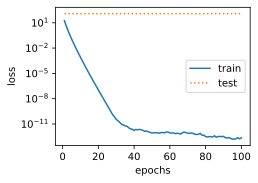

In [17]:
train_pytorch(0)

L2 norm of w: 0.0895337387919426


C:\Users\ZHANGWEIMING\AppData\Local\Temp\ipykernel_1296\1641065089.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


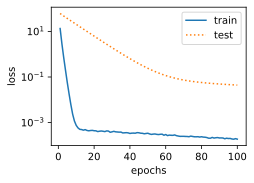

In [18]:
train_pytorch(1)